In [1]:
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import beam_propagation_method as bpm
import skimage.transform as skf
from scipy import optimize

# Initialize needed parameters (were already provided)

In [2]:
z_end   = 100       # propagation distance
lam     = 1         # wavelength
nd      = 1.455    # reference index
xa      = 50        # size of computational window
Nx      = 501       # number of transverse points
dx      = xa/(Nx-1) # transverse step size

# waveguide parameters
xb      = 2.0       # size of waveguide
n_cladding  = 1.45      # cladding index
n_core  = 1.46      # core refr. index

# source width
w       = 5.0       # Gaussian beam width

# propagation step size
dz = 0.5
output_step = 1
# create index distribution                                                        
n, x = bpm.waveguide(xa, xb, Nx, n_cladding, n_core)                                   
# create initial field                                                             
v_in, x = bpm.gauss(xa, Nx, w)                                                         
v_in = v_in/np.sqrt(np.sum(np.abs(v_in)**2)) # normalize power to unity 

# Method with factorization
a = timer()
v_out, z = bpm.beamprop_CN(v_in, lam, dx, n, nd, z_end, dz, output_step)
b = timer()
print("Time elapsed single precision and factorized matrix \t\t{:.5f}s".format(b - a))


# Method with spsolve 
a = timer()
a = timer()
v_out_s, z = bpm.beamprop_CN(v_in, lam, dx, n, nd, z_end, dz, 1, method="solve")
b = timer()
print("Time elapsed single precision without prefactozired matrix \t{:.5f}s".format(b - a))

# Method with invert 
a = timer()
v_out_i, z = bpm.beamprop_CN(v_in, lam, dx, n, nd, z_end, dz, 1, method="invert")
b = timer()
print("Time elapsed single precision with inverted matrix \t\t{:.5f}s".format(b - a))

# for plotting
extent = (0, z_end, x[0], x[-1])

Time elapsed single precision and factorized matrix 		0.00783s
Time elapsed single precision without prefactozired matrix 	0.03842s
Time elapsed single precision with inverted matrix 		0.90893s


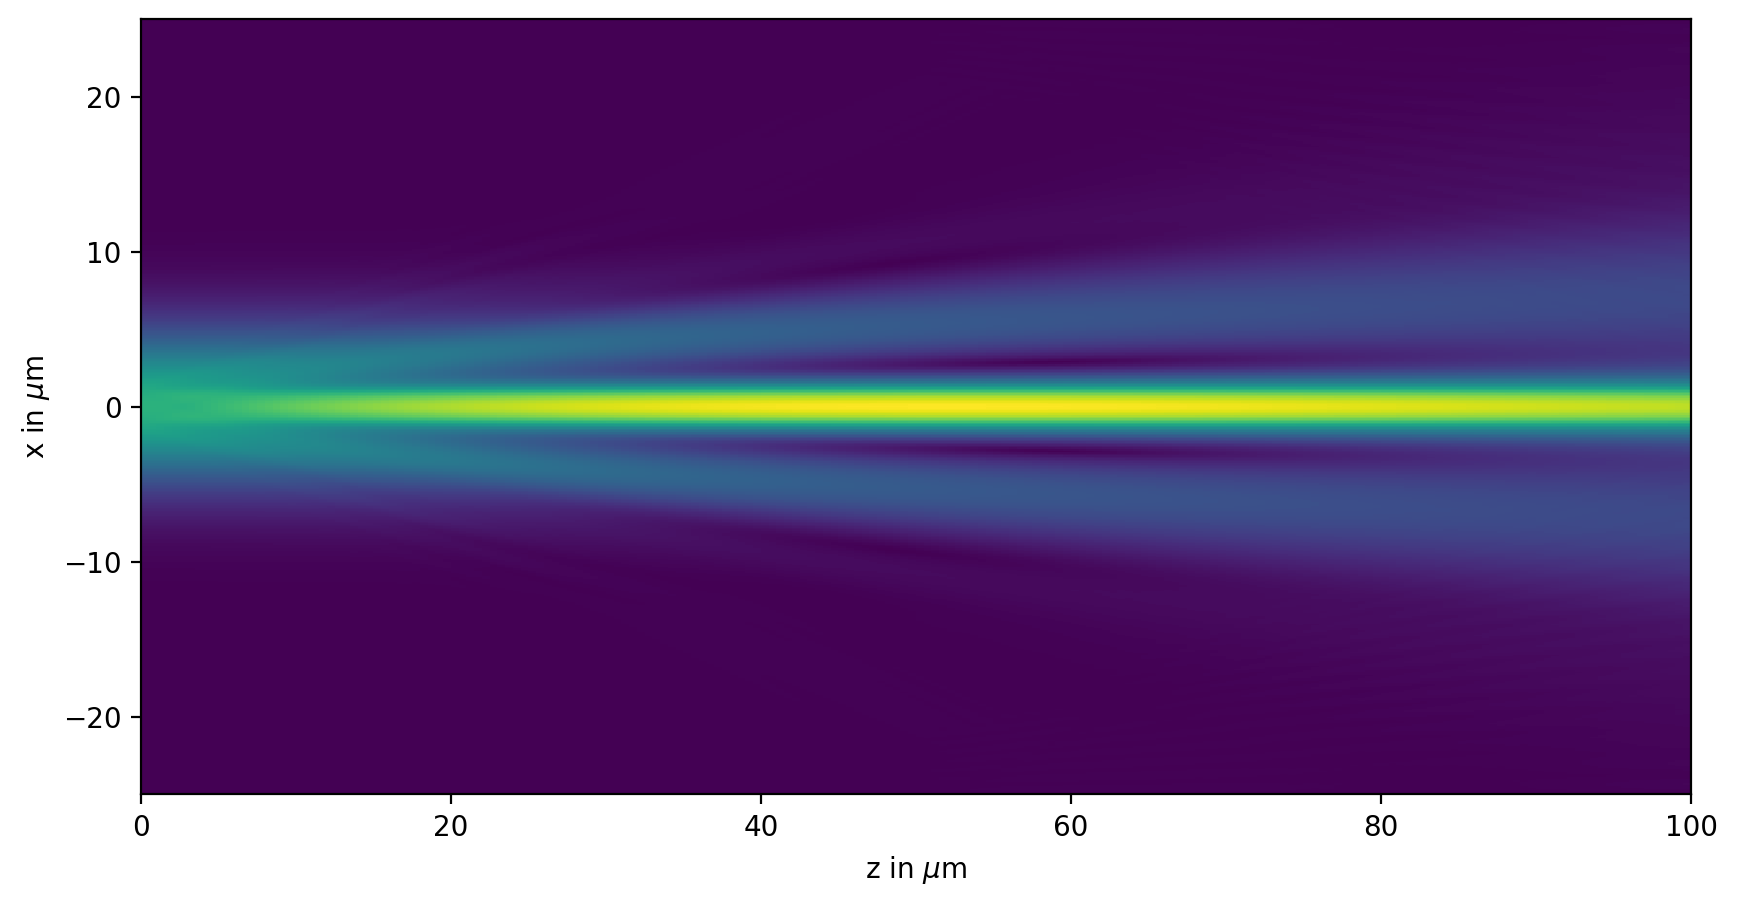

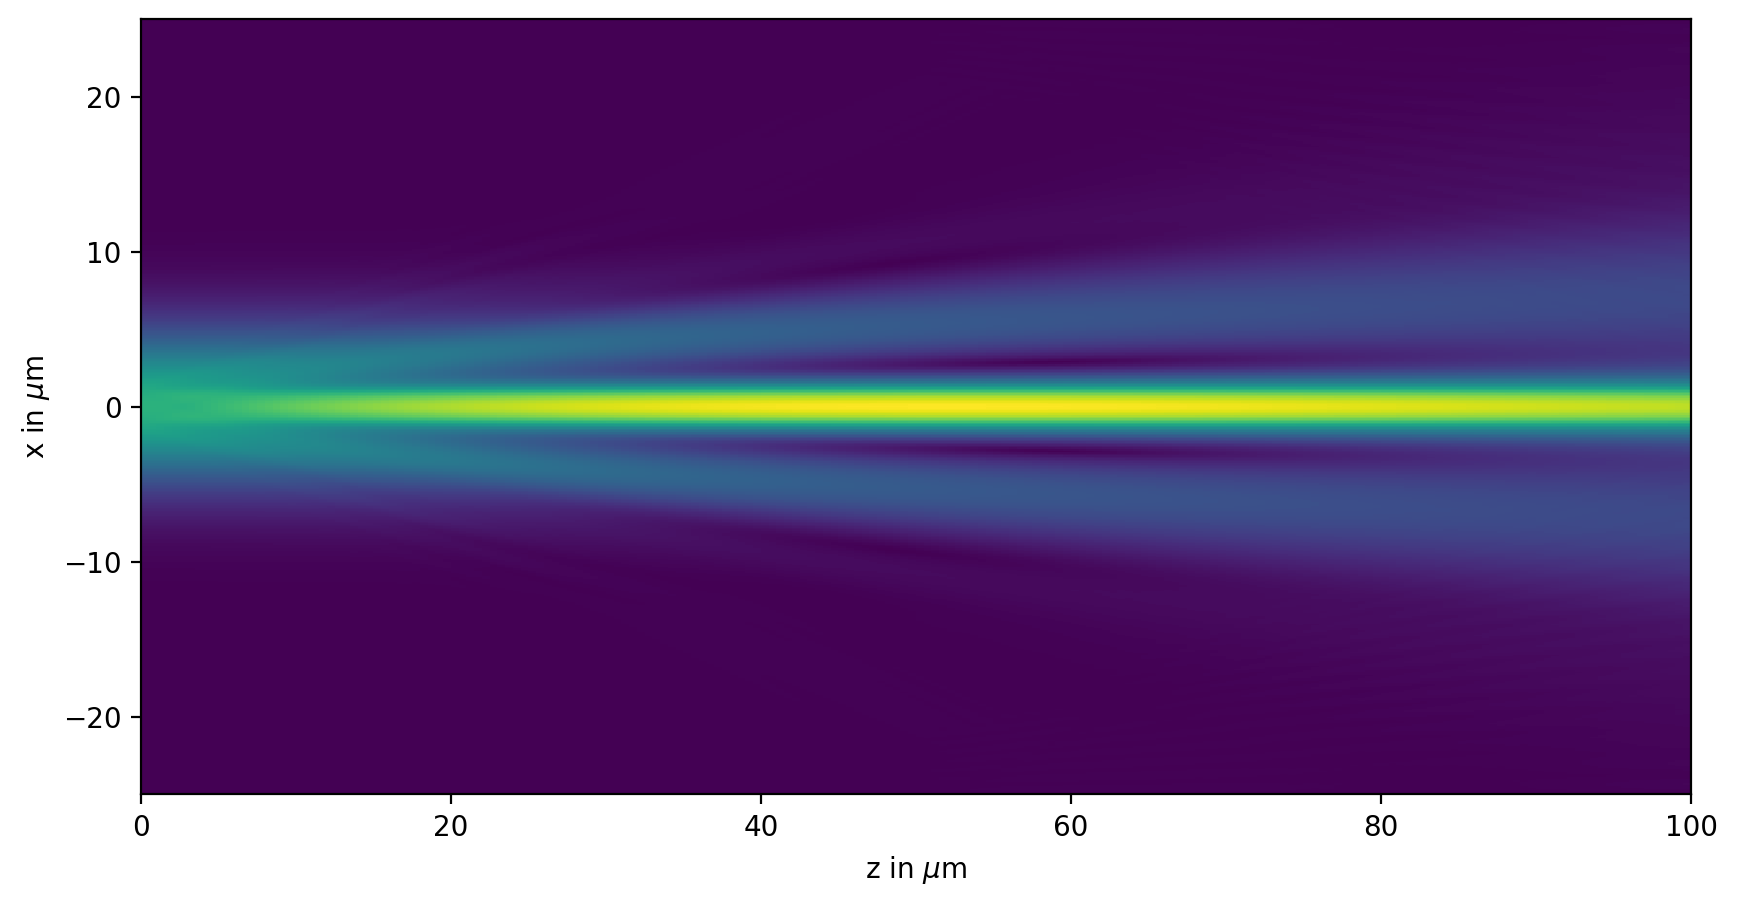

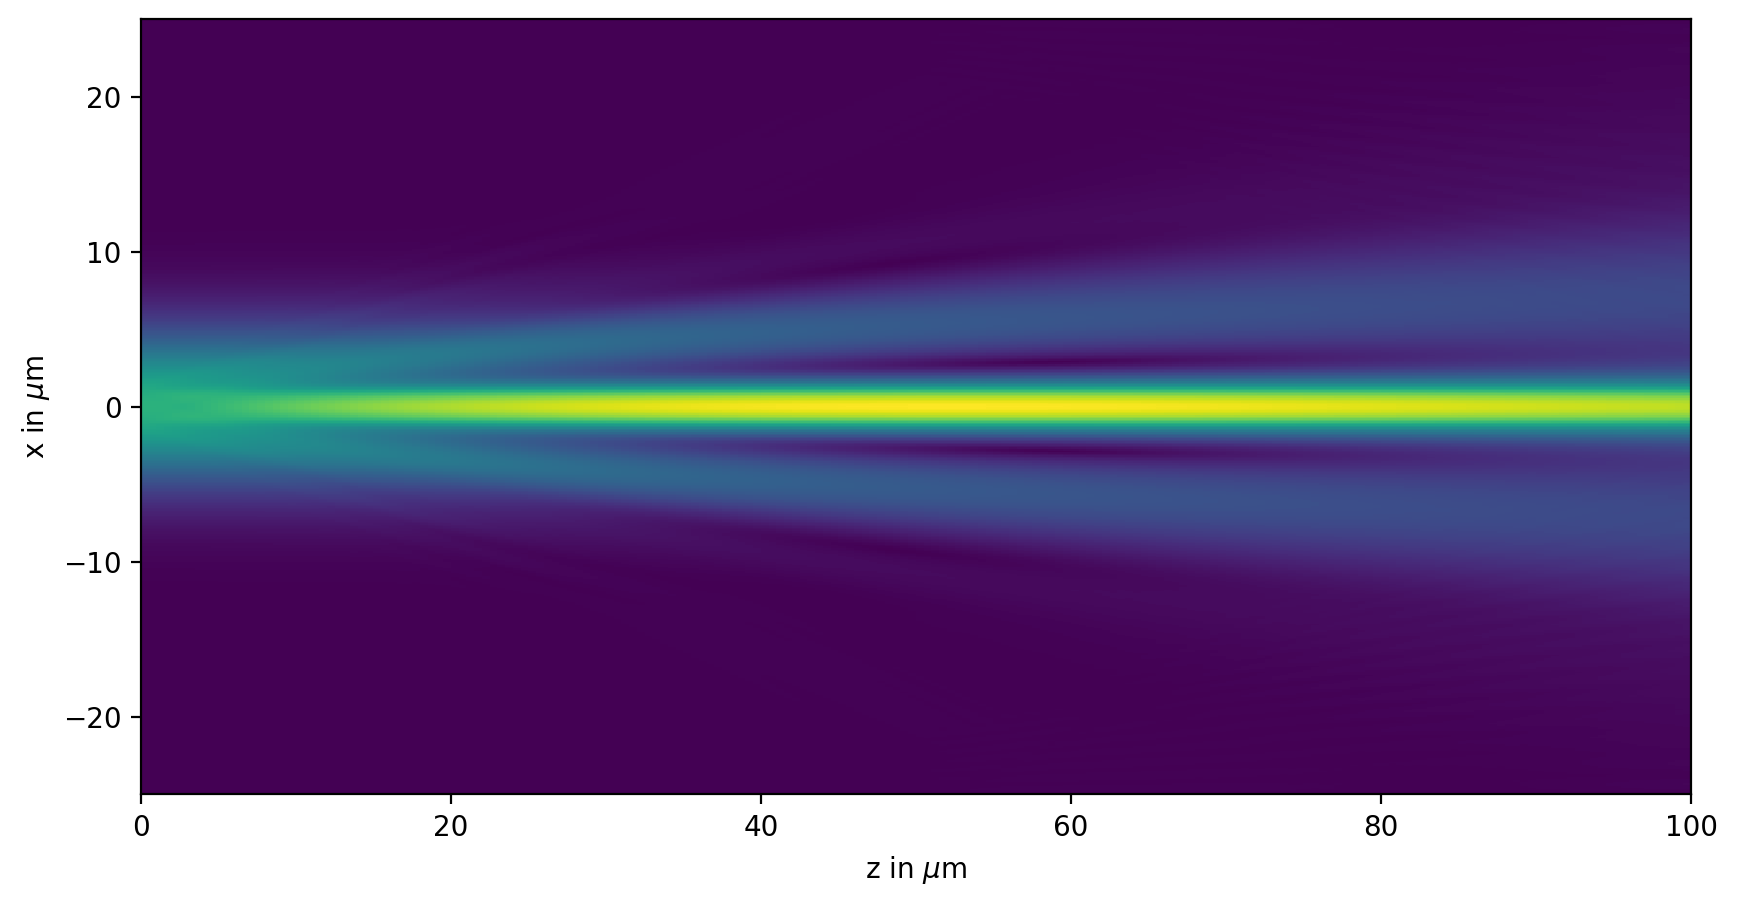

In [3]:
plt.figure(figsize=(10, 6), dpi=200, facecolor='w', edgecolor='k')
plt.xlabel(r"z in $\mu$m")
plt.ylabel(r"x in $\mu$m")
plt.imshow(np.transpose(np.abs(v_out)), extent=extent)

plt.figure(figsize=(10, 6), dpi=200, facecolor='w', edgecolor='k')
plt.xlabel(r"z in $\mu$m")
plt.ylabel(r"x in $\mu$m")
plt.imshow(np.transpose(np.abs(v_out_s)), extent=extent)

plt.figure(figsize=(10, 6), dpi=200, facecolor='w', edgecolor='k')
plt.xlabel(r"z in $\mu$m")
plt.ylabel(r"x in $\mu$m")
plt.imshow(np.transpose(np.abs(v_out_i)), extent=extent)

# Convergence check of different x sampling

The basic idea is to create a reference field with dense dx sampling.
We compare lower dx samplings with our reference field via the mean absolute error.
We can plot the difference over dx and expect a quadratic dependency

In [4]:
# as a first step calculate a high resolution field
Nx = 6000
dx = xa/(Nx-1) # transverse step size                                         
dz = 0.5
n, x = bpm.waveguide(xa, xb, Nx, n_cladding, n_core)                                   
# create initial field                                                             
v_in, x = bpm.gauss(xa, Nx, w)                                                         
v_in = v_in/np.sqrt(np.sum(np.abs(v_in)**2)) # normalize power to unity 
ref, _ = bpm.beamprop_CN(v_in, lam, dx, n, nd, z_end, dz, 1)
ref = np.abs(ref)



# error function to compare with a reference
def rel_error(v_out, ref):
    return np.mean(np.abs(v_out - ref)) 


losses = []
Nxs = [i  for i in range(100,10000, 200)]
dxs = []

# loop over different field resolutions
for Nx in Nxs:
    # create index distribution                                                        
    n, x = bpm.waveguide(xa, xb, Nx, n_cladding, n_core)                                   
    # create initial field                                                             
    v_in, x = bpm.gauss(xa, Nx, w)                                                         
    v_in = v_in/np.sqrt(np.sum(np.abs(v_in)**2)) # normalize power to unity 
    dx = xa/(Nx-1) # transverse step size                    
    dxs.append(dx)
    # simulate with new dx
    v_out, _ = bpm.beamprop_CN(v_in, lam, dx, n, nd, z_end, dz, 1)
    v_out = np.abs(v_out)
    v_out /= np.sum(v_out)
    # scale reference to same size
    ref_s = skf.resize(np.abs(ref), v_out.shape, order=3)
    # normalize it
    ref_s = np.abs(ref_s)
    ref_s /= np.sum(ref_s)
    # calculate loss and store it
    losses.append(rel_error(v_out[-1, :], ref_s[-1, :]))

Params [1.72683648e-05 2.22638579e+00]
Error [2.49513265e-07 2.06014922e-02]


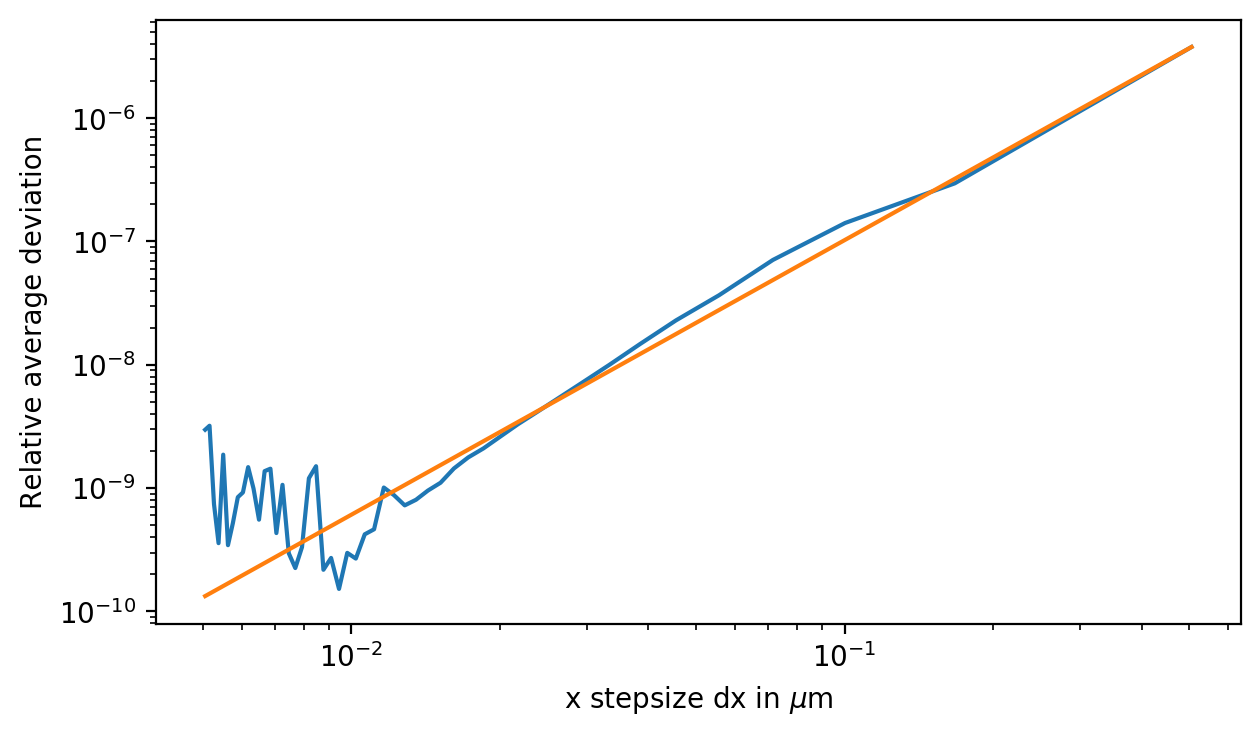

In [5]:
# fit function for convergence
def fit_f(x, a, b):
    return a * x ** b
# do the fitting
params, pcov= optimize.curve_fit(fit_f, dxs[:-10], losses[:-10], p0=[1, 2])


perr = np.sqrt(np.diag(pcov))
# show results
print("Params", params)
print("Error", perr)
plt.figure(figsize=(7, 4), dpi=200, facecolor='w', edgecolor='k')
plt.xlabel(r"x stepsize dx in $\mu$m")
plt.ylabel("Relative average deviation")
plt.loglog(dxs, losses)
plt.loglog(dxs, fit_f(dxs, params[0], params[1]))

# Convergence check of different z sampling

In [6]:
Nx = 2000
dx = xa/(Nx-1) # transverse step size                                         
z_end   = 10       # propagation distance
dz = 0.001
n, x = bpm.waveguide(xa, xb, Nx, n_cladding, n_core)                                   
# create initial field                                                             
v_in, x = bpm.gauss(xa, Nx, w)                                                         
v_in = v_in/np.sqrt(np.sum(np.abs(v_in)**2)) # normalize power to unity 
ref, _ = bpm.beamprop_CN(v_in, lam, dx, n, nd, z_end, dz, 1)

ref = np.abs(ref)
ref /= np.sum(ref)


losses = []
dzs = [dz * 1.3 ** i  for i in range(0, 31)]
# loop over different dz step size
for dz in dzs:
    n, x = bpm.waveguide(xa, xb, Nx, n_cladding, n_core)                                   
    v_in, x = bpm.gauss(xa, Nx, w)                                                         
    v_in = v_in/np.sqrt(np.sum(np.abs(v_in)**2)) # normalize power to unity
    # simulate
    v_out, _ = bpm.beamprop_CN(v_in, lam, dx, n, nd, z_end, dz, 1)
    v_out = np.abs(v_out)
    v_out /= np.sum(v_out)
    # compare the result at z_end
    losses.append(rel_error(v_out[-1, :], ref[-1, :]))

[5.07903267e-05 9.59030886e-01]
[5.77288528e-07 1.48992743e-02]


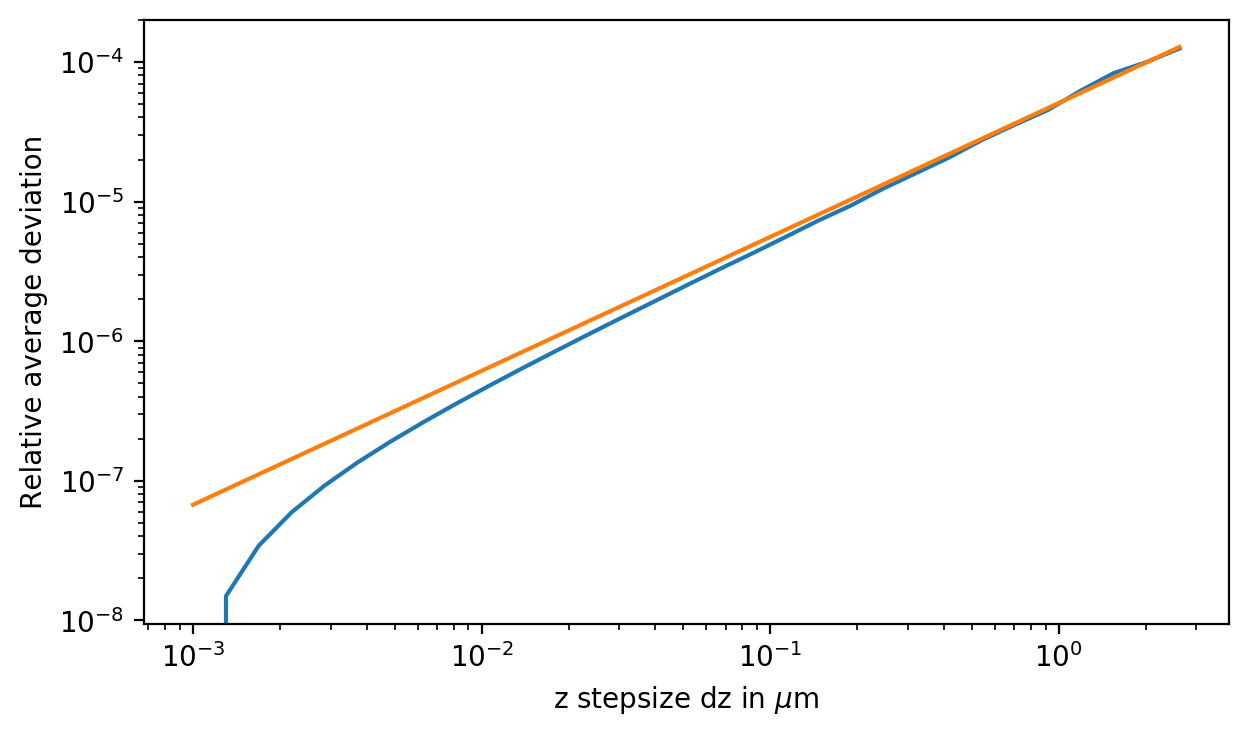

In [7]:
# do the fitting
params, pcov = optimize.curve_fit(fit_f, dzs[5:], losses[5:])
perr = np.sqrt(np.diag(pcov))

# show results
print(params)
print(perr)
plt.figure(figsize=(7, 4), dpi=200, facecolor='w', edgecolor='k')
plt.xlabel(r"z stepsize dz in $\mu$m")
plt.ylabel("Relative average deviation")
plt.loglog(dzs, losses)
plt.loglog(dzs, fit_f(dzs, params[0], params[1]))